# Clasificador de Reptiles o Anfibios con una CNN.  
### Fine Tuning a Resnet50

### Comencemos cargando el dataset desde una cuenta de Google Drive. Está dividido en 2 carpetas de imágenes clasificadas: "Anfibios" y "Reptiles".

In [3]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

# Set ruta_principal to the path of the folder in your Drive
ruta_principal = '/content/drive/My Drive/Colab Notebooks/ProyectoML/dataset'


Mounted at /content/drive


#### Veamos cuántas imágenes de cada clase tenemos

In [15]:
import os

ruta_principal = '/content/drive/My Drive/Colab Notebooks/ProyectoML/dataset'

# Number of images on each subfolder
conteos = {}
for carpeta in os.listdir(ruta_principal):
    ruta_carpeta = os.path.join(ruta_principal, carpeta)
    if os.path.isdir(ruta_carpeta):
        numero_imagenes = len([archivo for archivo in os.listdir(ruta_carpeta) if os.path.isfile(os.path.join(ruta_carpeta, archivo))])
        conteos[carpeta] = numero_imagenes

# Print the number of images per folder
for carpeta, conteo in conteos.items():
    print(f"Carpeta '{carpeta}': {conteo} imágenes")

Carpeta 'Anfibios': 2978 imágenes
Carpeta 'Reptiles': 8975 imágenes


Nótese que tenemos mas reptiles que anfibios

## Carguemos las imágenes  
Carguemos las imágenes y dividámoslas en trainging y validation

In [16]:
import os
import shutil
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import random_split

# Transformations for the images
transformaciones = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load the dataset
dataset = torchvision.datasets.ImageFolder(root=ruta_principal, transform=transformaciones)

# Size of the Training and Validation sets
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size

# Split the dataset in Training and Validation
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(f"Entrenamiento: {len(train_dataset)} imágenes, Prueba: {len(test_dataset)} imágenes")


Entrenamiento: 9561 imágenes, Prueba: 2391 imágenes


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Carguemos la resnet 50

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader

# Loading the pretrained model
model = models.resnet50(pretrained=True)

# Freezing the parameters
for param in model.parameters():
    param.requires_grad = False

# Modify the last layer fully connected
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 outputs: Anfibios y Reptiles

# Defining the training device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda:0


In [18]:
import matplotlib.pyplot as plt
#Define the loss criteria and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# DataLoader for the Training and Validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


def calcular_precision(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels).item()

def train_model(model, criterion, optimizer, num_epochs=10):
    train_loss_history = []
    train_acc_history = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += calcular_precision(outputs, labels)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)

        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    return model, train_loss_history, train_acc_history

# Entrenar el modelo y obtener historiales



In [19]:
trained_model, loss_history, acc_history = train_model(model, criterion, optimizer, num_epochs=10)

Epoch 1/10, Loss: 0.1971, Accuracy: 0.9262
Epoch 2/10, Loss: 0.1672, Accuracy: 0.9406
Epoch 3/10, Loss: 0.1597, Accuracy: 0.9406
Epoch 4/10, Loss: 0.1575, Accuracy: 0.9418
Epoch 5/10, Loss: 0.1547, Accuracy: 0.9448
Epoch 6/10, Loss: 0.1525, Accuracy: 0.9461
Epoch 7/10, Loss: 0.1499, Accuracy: 0.9439
Epoch 8/10, Loss: 0.1400, Accuracy: 0.9488
Epoch 9/10, Loss: 0.1470, Accuracy: 0.9462
Epoch 10/10, Loss: 0.1423, Accuracy: 0.9489


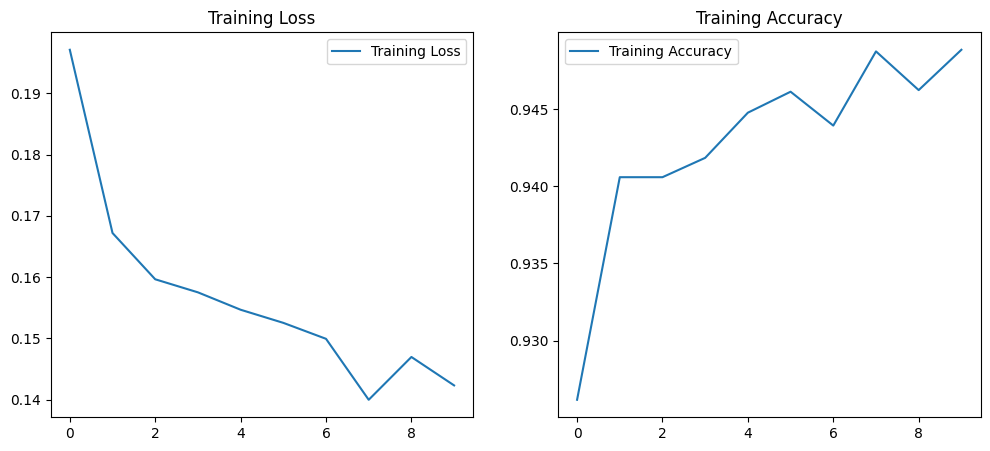

In [25]:
# Plot Loss and Accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Training Loss')
plt.title('Training Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(acc_history, label='Training Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

In [22]:
# Defrosting all the model's layers
for param in model.parameters():
    param.requires_grad = True

# Define the optimizer again, now for all the layers
optimizer_fine_tuning = optim.Adam(model.parameters(), lr=0.0001)  # Lower learning rate

# Fine-tuning from the model
trained_model_fine_tuned, loss_history_fine_tuned, acc_history_fine_tuned = train_model(
    model, criterion, optimizer_fine_tuning, num_epochs=5)  # Less Epoch number fot fine-tuning

Epoch 1/5, Loss: 0.1499, Accuracy: 0.9463
Epoch 2/5, Loss: 0.0558, Accuracy: 0.9808
Epoch 3/5, Loss: 0.0501, Accuracy: 0.9834
Epoch 4/5, Loss: 0.0355, Accuracy: 0.9883
Epoch 5/5, Loss: 0.0294, Accuracy: 0.9909


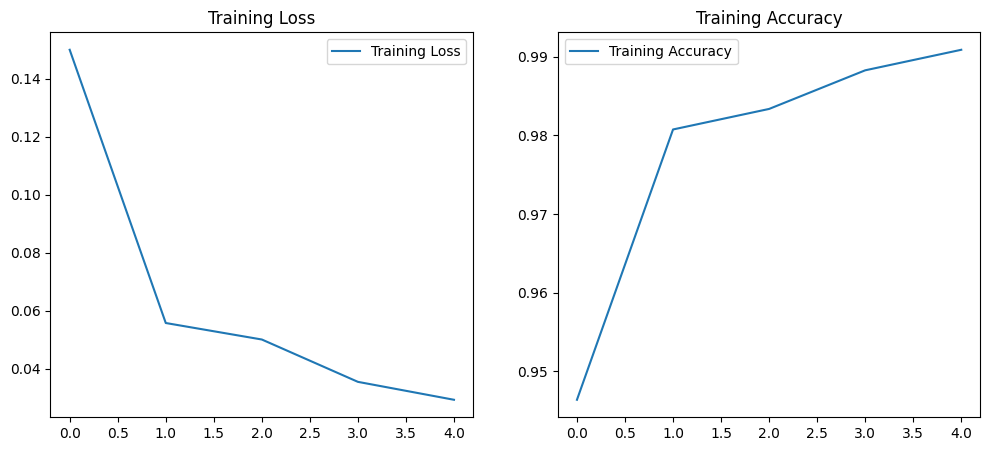

In [26]:
# Plot Loss and Accuracy from the fine-tuning
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history_fine_tuned, label='Training Loss')
plt.title('Training Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(acc_history_fine_tuned, label='Training Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

### Salvamos el modelo

In [23]:
torch.save(model.state_dict(), 'resnet50_anfibios_reptiles.pth')

### Graficamos datos interesantes:

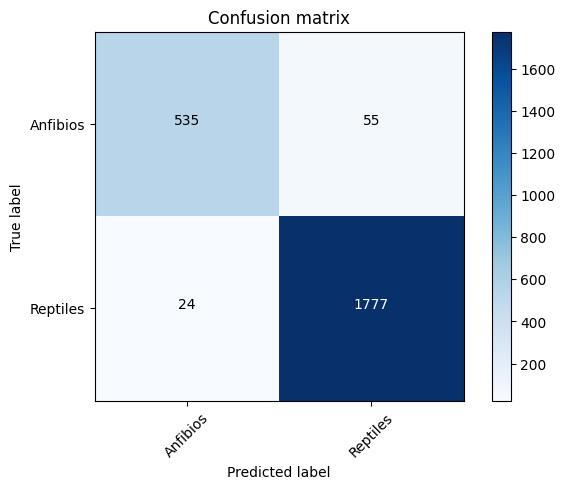

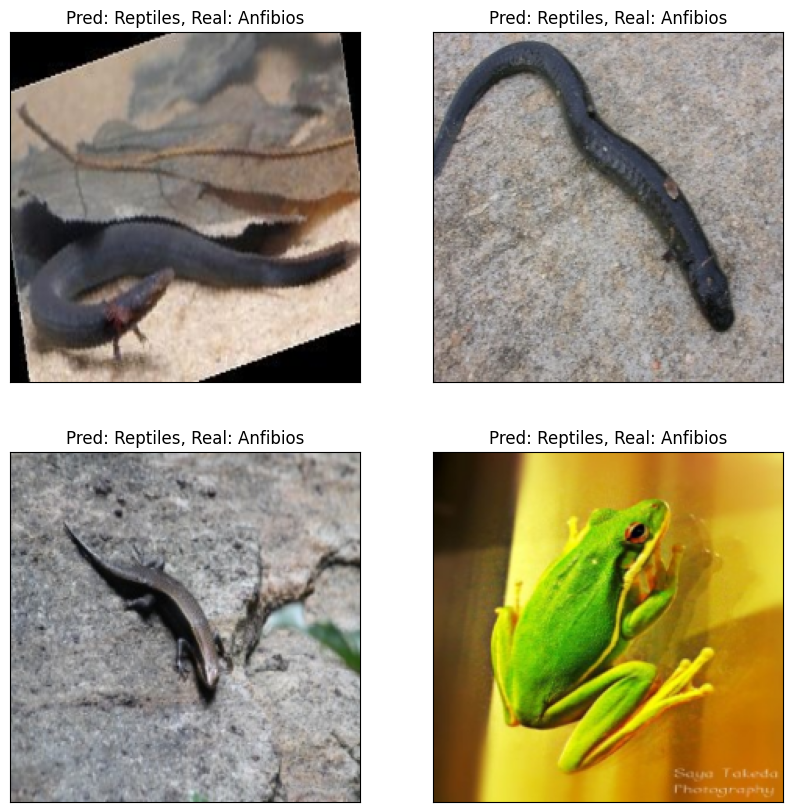

In [24]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Function for Confusion Matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

y_pred = []
y_true = []

model.eval()  # Set model to evaluation mode

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.view(-1).tolist())
        y_true.extend(labels.view(-1).tolist())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, classes=['Anfibios', 'Reptiles'])

# Show wrong images
fig = plt.figure(figsize=(10, 10))

incorrects = np.where(np.array(y_pred) != np.array(y_true))[0]
if incorrects.size > 0:
    for i, incorrect in enumerate(incorrects[:4]):  # Only the first four
        ax = fig.add_subplot(2, 2, i+1, xticks=[], yticks=[])
        img, label = test_dataset[incorrect]
        img = img.cpu().numpy().transpose((1, 2, 0))
        ax.imshow(img)
        ax.set_title(f'Pred: {["Anfibios", "Reptiles"][y_pred[incorrect]]}, Real: {["Anfibios", "Reptiles"][y_true[incorrect]]}')

plt.show()